# Preprocessing and Feature Engineering

This notebook is dedicated to preprocessing our data into a clean data set, and feature engineering our training datasets in preparation for modeling.

## Library Imports

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## preprocessing - NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [270]:
%run 00_Workflow_Functions.ipynb import na_only

In [422]:
stored_data = {} #data to be stored and shared across other notebooks

In [291]:
subs = pd.read_csv('../datasets/submissions_data.csv')
subs.shape

(9717, 10)

## Data Cleaning

In [292]:
subs.head(5)

,author,author_fullname,created_utc,selftext,title,subreddit,is_video,num_comments,score,upvote_ratio
0,anonymousbrowzer,t2_14k10v,1.648770e+09,NaN,"When the smoke detector goes off from cooking,...",lifehacks,False,0.0,1.0,1.0
1,PlantBasedRedditor,t2_g4e0rfz,1.648767e+09,NaN,Use Goo Gone on scissors and blades to reduce ...,lifehacks,False,0.0,1.0,1.0
2,CryptographerFar5073,t2_ldjcr311,1.648764e+09,NaN,Bingo Bash,lifehacks,False,0.0,1.0,1.0
3,Giant_weiner_not_dog,t2_konlr4kt,1.648763e+09,NaN,How to troll someone,lifehacks,False,0.0,1.0,1.0
4,Giant_weiner_not_dog,t2_konlr4kt,1.648762e+09,NaN,what a nice way to have your meal( credit to u...,lifehacks,False,0.0,1.0,1.0


In [293]:
subs.tail(5)

,author,author_fullname,created_utc,selftext,title,subreddit,is_video,num_comments,score,upvote_ratio
9712,sscorpio77,t2_jugpp8rg,1.646173e+09,[removed],LPT: You won’t have to constantly brake to avo...,LifeProTips,False,2.0,1.0,1.0
9713,CreatorVilla,t2_f1xkvrju,1.646173e+09,NaN,"LPT: If you want someone to trust you, approac...",LifeProTips,False,1.0,1.0,1.0
9714,TheNative93,t2_52ulcx1x,1.646173e+09,"If they have a number on their website, or on ...",LPT Whenever you submit a resume don’t wait fo...,LifeProTips,False,1.0,1.0,1.0
9715,duskymk,t2_22umtf1d,1.646173e+09,[removed],LPT: Always bring your phone with you in a pub...,LifeProTips,False,1.0,1.0,1.0
9716,shwarma_heaven,t2_ddvb4,1.646172e+09,NaN,LPT: Just because a car stops before a parking...,LifeProTips,False,1.0,1.0,1.0


In [294]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9717 entries, 0 to 9716
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   author           9717 non-null   object 
 1   author_fullname  9717 non-null   object 
 2   created_utc      9717 non-null   float64
 3   selftext         5557 non-null   object 
 4   title            9717 non-null   object 
 5   subreddit        9717 non-null   object 
 6   is_video         9717 non-null   bool   
 7   num_comments     9717 non-null   float64
 8   score            9717 non-null   float64
 9   upvote_ratio     9717 non-null   float64
dtypes: bool(1), float64(4), object(5)
memory usage: 692.8+ KB


In [295]:
na_only(subs)

selftext    4160
dtype: int64

When we wrangled the data, we had no NAs reported. However, after exporting the CSV and importing the CSV, we now have NAs present. Also, there appears to be a particular value `[removed]` that indicates a submission was deleted, and data was redacted. We will need to drop all of this data for NLP, as it's not useful for us.

In [296]:
subs['subreddit'].value_counts(normalize=True)

lifehacks      0.520119
LifeProTips    0.479881
Name: subreddit, dtype: float64

Prior to dropping NAs, we have a nearly perfectly balance proportion between our two classes.

Our data is likley to contain spam content from bots. What if we dropped all posts that have a score less than 2? Let's see how viable that is.

In [297]:
subs[subs['score'] > 0].shape

(9680, 10)

In [298]:
subs[subs['score'] > 1].shape

(98, 10)

By simply excluding posts with a score of 1, we end up with very little data... not a viable strategy.

Let's drop NAs from our dataset entirely, since only `selftext` data with content is relevant for us.

In [299]:
# dropping NAs
subs = subs.dropna()
#subs.reset_index(drop=True, inplace=True) #resetting index after dropping rows
subs.shape

(5557, 10)

In addition NAs, let's remove `[removed]` and selftext posts that are less than `7` words long (subjective choice). We do this because a post of a few words may indicate the post is referencing a multimedia file or hypyerlink, which is noise that will affect our model performance.

In [300]:
#storing all (index,value) pairs of erraneous data in an array
text_filter = np.array([[i, text] for i, text in enumerate(subs['selftext']) if len(str(text).split()) < 10]) 

In [301]:
pd.DataFrame(text_filter[:, 1]).value_counts()

[removed]                                                                                                        2933
to avoid their insanely high prices this summer!                                                                    2
Original:\nhttps://m.youtube.com/watch?v=SQNtGoM3FVU\n\nFor download:\nhttps://m.yout.com/watch?v=SQNtGoM3FVU       2
\n\n[View Poll](https://www.reddit.com/poll/rjy7cm)                                                                 1
Went to make cookies and this did the trick.                                                                        1
                                                                                                                 ... 
It's the most commonly used utensil.                                                                                1
It’s less risky, and you can eat the evidence.                                                                      1
It’s simply satisfying.                                 

In [302]:
ind = list(text_filter[:, 0].astype(int)) #these indices contain the erraneous data
ind[:10]

[0, 3, 4, 6, 7, 8, 9, 10, 11, 12]

In [303]:
subs.iloc[ind, 3] = None

In [304]:
print(len(ind), subs.iloc[ind, 3].isna().sum())

3081 3081


Values match; we have replaced all erraneous text as NAs and we will now drop them.

In [305]:
# dropping NAs
subs = subs.dropna()
subs.shape

(2476, 10)

In [306]:
na_only(subs)

0

In [307]:
subs['subreddit'].value_counts(normalize=True)

LifeProTips    0.758885
lifehacks      0.241115
Name: subreddit, dtype: float64

After dropping NAs, `LifeProTips` has become our majority class.

Let's explort our clean data. Uncomment code below to export data to CSV.

In [308]:
#subs.to_csv('../datasets/submissions_data_cleaned.csv', index=False)

## Train and Test Splits

Splitting our data to train and test our model performances.

In [310]:
# we are only interested in the self-text
X = subs['selftext']
y = subs['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, stratify=y)

In [311]:
print(X_train.shape, X_test.shape)

(1857,) (619,)


In [312]:
print(y_train.shape, y_test.shape)

(1857,) (619,)


In [314]:
y_test.value_counts(normalize=True) #verifying stratification

LifeProTips    0.759289
lifehacks      0.240711
Name: subreddit, dtype: float64

## Encoding Response

Transforming our response into labels of 1 and 0, where `lifehacks : 1` and `LifeProTips : 0`.

In [315]:
le = LabelEncoder()

In [316]:
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [317]:
pd.DataFrame(y_train_encoded).value_counts(normalize=True)

0    0.758751
1    0.241249
dtype: float64

Although we started off with a strongly balanced proportion of positive and negative classes, after preprocessing our data we now have dataset that is fairly unbalanced. This may affect our model performance down the road. We may be able to mitigate this by wrangling more data from the subreddits. We will proceed for now.

## Feature Engineering

We will engineer our features iteratively, as we build and evaluate model performances on the features. We go back and forth between this notebook and `03_Models_Benchmarks`.

In [ ]:
cvec = CountVectorizer()

In [322]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).A, columns=cvec.get_feature_names_out())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).A, columns=cvec.get_feature_names_out())
X_train_cvec.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [332]:
# verifying column size match
print(X_train_cvec.shape, X_test_cvec.shape)

(1857, 12373) (619, 12373)


In [327]:
cvec_top_10 = X_train_cvec.sum().sort_values(ascending=False)[:10]

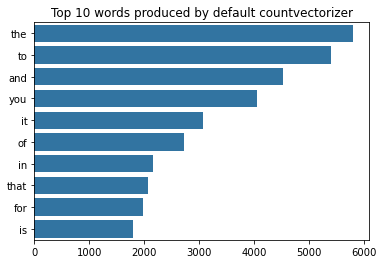

In [328]:
sns.barplot(y=list(cvec_top_10.index), x=cvec_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 words produced by default countvectorizer")
#plt.savefig('../images/top_10_cvec');

There are vast amounts of stop words (nouns and pronouns) in our submission data. Let's try and cut them down using the default stopwords list in the vectorizer.

In [329]:
cvec2 = CountVectorizer(stop_words='english')

In [330]:
X_train_cvec2 = pd.DataFrame(cvec2.fit_transform(X_train).A, columns=cvec2.get_feature_names_out())
X_test_cvec2 = pd.DataFrame(cvec2.transform(X_test).A, columns=cvec2.get_feature_names_out())
X_train_cvec2.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [333]:
# verifying column size match
print(X_train_cvec2.shape, X_test_cvec2.shape)

(1857, 12084) (619, 12084)


In [97]:
X_train_cvec2.shape[1] - X_train_cvec.shape[1]

-289

We have 289 less columns in our vectorized features without stop words compared to the default vectorization.

In [334]:
cvec2_top_10 = X_train_cvec2.sum().sort_values(ascending=False)[:10]

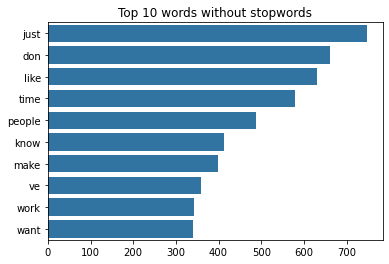

In [335]:
sns.barplot(y=list(cvec2_top_10.index), x=cvec2_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 words without stopwords")
#plt.savefig('../images/top_10_cvec2');

Stop words have been cut down; however, the frequency of the top 10 words has significantly decreased. We also have a lot more adverbs. <br />
Let's now tokenize our words (without stop words) using uni- and bigrams, and see what patterns emerge.

In [336]:
cvec3 = CountVectorizer(stop_words='english', ngram_range=(2, 2))

In [337]:
X_train_cvec3 = pd.DataFrame(cvec3.fit_transform(X_train).A, columns=cvec3.get_feature_names_out())
X_test_cvec3 = pd.DataFrame(cvec3.transform(X_test).A, columns=cvec3.get_feature_names_out())
X_train_cvec3.head(5)

,00 apy,00 didn,00 lowest,00 mashing,00 pair,000 100,000 11,000 calories,000 doubled,000 dual,...,還是因為距離 還是因為每個人各自的苦衷,還會陷入愛情嗎 即便再來一次,那些懵懂而青澀的過往 卻會是我們一生的珍藏,那些沒有結果的感情 結局不完美,那個你本以為忘記的人 就會像蜜蜂蟄了心,都成眷屬 人生有得失,都會實現 不是每一對戀人,都會結果 不是每一次心願,都有可能改變你的生活 主播,餘生 希望彼此都能把對方放下
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
# verifying column size match
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [339]:
X_train_cvec3.shape[1] - X_train_cvec.shape[1]

53141

We have 53,141 more columns by tokenizing our words into uni- and bigrams compared to the default vectorization.

In [340]:
cvec3_top_10 = X_train_cvec3.sum().sort_values(ascending=False)[:10]

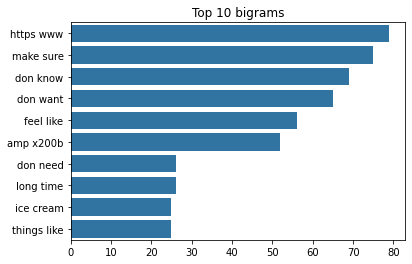

In [342]:
sns.barplot(y=list(cvec3_top_10.index), x=cvec3_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 bigrams")
#plt.savefig('../images/top_10_cvec3');

A fair amount of bigrams appear to include the word "don" which seems to be a typo of the word "don't". Typos are noise that will likely decrease the performances of our models.

Let's capture words that fall more in between the minimum and maximum occurences. We will drop tokens that appear only once or that appear more than 5% when compared to other token frequencies.

In [343]:
cvec4 = CountVectorizer(stop_words='english', min_df=2, max_df=.05)

In [344]:
X_train_cvec4 = pd.DataFrame(cvec4.fit_transform(X_train).A, columns=cvec4.get_feature_names_out())
X_test_cvec4 = pd.DataFrame(cvec4.transform(X_test).A, columns=cvec4.get_feature_names_out())
X_train_cvec4.head(5)

,00,000,03,04,09,10,100,1000,10mm,10pm,...,youtube,youtubers,yr,ysk,yt,zero,zip,zipper,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
# verifying column size match
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [346]:
X_train_cvec4.shape[1] - X_train_cvec.shape[1]

-6678

We have 6678 less columns here when compared to the default vectorization.

In [347]:
cvec4_top_10 = X_train_cvec4.sum().sort_values(ascending=False)[:10]

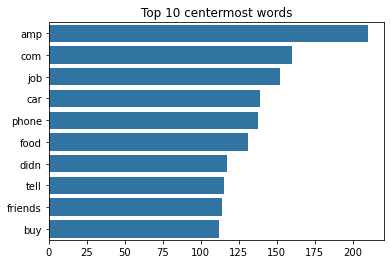

In [349]:
sns.barplot(y=list(cvec4_top_10.index), x=cvec4_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost words")
#plt.savefig('../images/top_10_cvec4');

----

Let's now explore more obscure words using the term frequency inverse document frequency.

In [350]:
tf = TfidfVectorizer()

In [351]:
X_train_tf = pd.DataFrame(tf.fit_transform(X_train).A, columns=tf.get_feature_names_out())
X_test_tf = pd.DataFrame(tf.transform(X_test).A, columns=tf.get_feature_names_out())
X_train_tf.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [352]:
# verifying column size match
print(X_train_tf.shape, X_test_tf.shape)

(1857, 12373) (619, 12373)


In [353]:
X_train_tf.shape[1] - X_train_cvec.shape[1]

0

No difference in columns size when compared to the default vectorization.

In [354]:
tf_top_10 = X_train_tf.sum().sort_values(ascending=False)[:10]

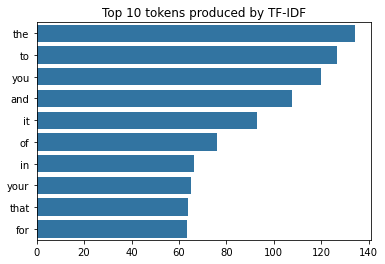

In [364]:
sns.barplot(y=list(tf_top_10.index), x=tf_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 tokens produced by TF-IDF")
#plt.savefig('../images/top_10_tf');

Let's remove stop words in our TF-IDF tokenization.

In [357]:
tf2 = TfidfVectorizer(stop_words='english')

In [358]:
X_train_tf2 = pd.DataFrame(tf2.fit_transform(X_train).A, columns=tf2.get_feature_names_out())
X_test_tf2 = pd.DataFrame(tf2.transform(X_test).A, columns=tf2.get_feature_names_out())
X_train_tf2.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [359]:
# verifying column size match
print(X_train_tf2.shape, X_test_tf2.shape)

(1857, 12084) (619, 12084)


In [360]:
X_train_tf2.shape[1] - X_train_cvec.shape[1]

-289

We have 289 less columns here when compared to the default vectorization.

In [362]:
tf2_top_10 = X_train_tf2.sum().sort_values(ascending=False)[:10]

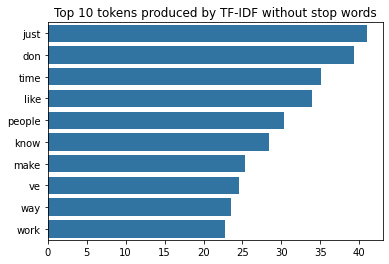

In [372]:
sns.barplot(y=list(tf2_top_10.index), x=tf2_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 tokens produced by TF-IDF without stop words");
#plt.savefig('../images/top_10_tf2');

Let's capture words that fall more in between the minimum and maximum occurences. We will drop tokens that appear only once or that appear more than 5% when compared to other token frequencies.

In [366]:
tf3 = TfidfVectorizer(min_df=2, max_df=.05)

In [367]:
X_train_tf3 = pd.DataFrame(tf3.fit_transform(X_train).A, columns=tf3.get_feature_names_out())
X_test_tf3 = pd.DataFrame(tf3.transform(X_test).A, columns=tf3.get_feature_names_out())
X_train_tf3.head(5)

,00,000,03,04,09,10,100,1000,10mm,10pm,...,youtube,youtubers,yr,ysk,yt,zero,zip,zipper,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.018179,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [368]:
# verifying column size match
print(X_train_tf3.shape, X_test_tf3.shape)

(1857, 5849) (619, 5849)


In [369]:
X_train_tf3.shape[1] - X_train_cvec.shape[1]

-6524

We have 6524 less columns here when compared to the default vectorization.

In [370]:
tf3_top_10 = X_train_tf3.sum().sort_values(ascending=False)[:10]

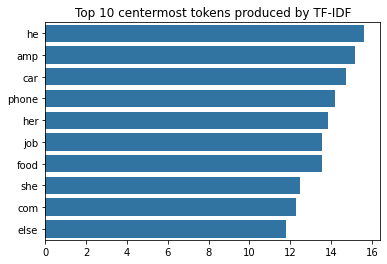

In [375]:
sns.barplot(y=list(tf3_top_10.index), x=tf3_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost tokens produced by TF-IDF")
#plt.savefig('../images/top_10_tf3');

Let's restrict the frequencies even more, and see what patterns emerge.

In [376]:
tf4 = TfidfVectorizer(min_df=15, max_df=.05)

In [377]:
X_train_tf4 = pd.DataFrame(tf4.fit_transform(X_train).A, columns=tf4.get_feature_names_out())
X_test_tf4 = pd.DataFrame(tf4.transform(X_test).A, columns=tf4.get_feature_names_out())
X_train_tf4.head(5)

,10,100,12,15,20,25,30,50,able,above,...,writing,wrong,www,x200b,year,yes,yet,young,youtube,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.27878,0.0,0.0,0.0,0.149714,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038148,...,0.081017,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.040509
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [379]:
# verifying column size match
print(X_train_tf4.shape, X_test_tf4.shape)

(1857, 863) (619, 863)


In [380]:
X_train_tf4.shape[1] - X_train_cvec.shape[1]

-11510

We have 11,510 less columns here when compared to the default vectorization.

In [381]:
tf4_top_10 = X_train_tf4.sum().sort_values(ascending=False)[:10]

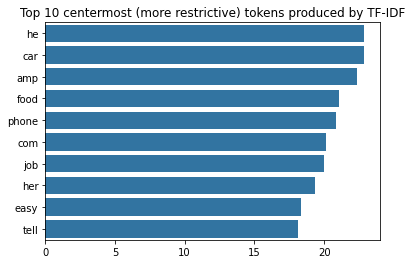

In [384]:
sns.barplot(y=list(tf4_top_10.index), x=tf4_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost (more restrictive) tokens produced by TF-IDF")
#plt.savefig('../images/top_10_tf4');

Let's take the same restrictive parameters and create bigrams.

In [385]:
tf5 = TfidfVectorizer(min_df=15, max_df=.05, ngram_range=(2, 2))

In [386]:
X_train_tf5 = pd.DataFrame(tf5.fit_transform(X_train).A, columns=tf5.get_feature_names_out())
X_test_tf5 = pd.DataFrame(tf5.transform(X_test).A, columns=tf5.get_feature_names_out())
X_train_tf5.head(5)

,able to,about how,about it,about the,about this,about what,after the,all my,all of,all you,...,you would,you you,your body,your car,your friends,your life,your mind,your own,your phone,your time
0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.1638,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.067396,0.068213,0.0,0.07389,0.0,0.0,0.0,0.0,...,0.07389,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [387]:
# verifying column size match
print(X_train_tf5.shape, X_test_tf5.shape)

(1857, 758) (619, 758)


In [388]:
X_train_tf5.shape[1] - X_train_cvec.shape[1]

-11615

We have 11,615 less columns here when compared to the default vectorization.

In [389]:
tf5_top_10 = X_train_tf5.sum().sort_values(ascending=False)[:10]

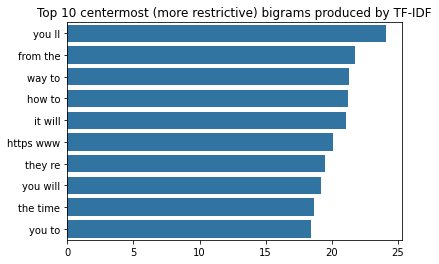

In [391]:
sns.barplot(y=list(tf5_top_10.index), x=tf5_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost (more restrictive) bigrams produced by TF-IDF")
#plt.savefig('../images/top_10_tf5');

----

Our last engineering process will be lemmatization of the words. Let's see what patterns we find.

In [392]:
## Creating lemmatization class
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(word) for word in word_tokenize(doc)]

In [393]:
lt = CountVectorizer(tokenizer=LemmaTokenizer())
lt

CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x0000026AF50FE820>)

In [394]:
X_train_lt = pd.DataFrame(lt.fit_transform(X_train).A, columns=lt.get_feature_names_out())
X_test_lt = pd.DataFrame(lt.transform(X_test).A, columns=lt.get_feature_names_out())
X_train_lt.head(5)

,!,#,$,%,&,','','actually,'advice,'alpha,...,🙏,🙏❤️,🛑,🤒,🤮,🥑,🥶,🧵,🪖,🪡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [395]:
# verifying column size match
print(X_train_lt.shape, X_test_lt.shape)

(1857, 11800) (619, 11800)


In [352]:
X_train_lt.shape[1] - X_train_cvec.shape[1]

-573

We have 573 less columns here when compared to the default vectorization.

In [396]:
lt_top_10 = X_train_lt.sum().sort_values(ascending=False)[:10]

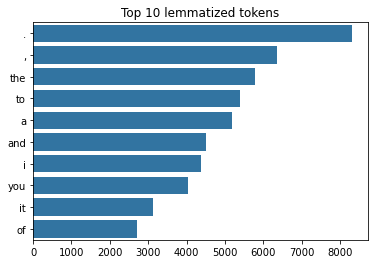

In [399]:
sns.barplot(y=list(lt_top_10.index), x=lt_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 lemmatized tokens")
#plt.savefig('../images/top_10_lt');

Let's restrict the highest and lowest frequencies, and see what patterns emerge.

In [400]:
lt2 = CountVectorizer(tokenizer=LemmaTokenizer(), min_df=5, max_df=.03)

In [401]:
X_train_lt2 = pd.DataFrame(lt2.fit_transform(X_train).A, columns=lt2.get_feature_names_out())
X_test_lt2 = pd.DataFrame(lt2.transform(X_test).A, columns=lt2.get_feature_names_out())
X_train_lt2.head(5)

,#,',+,--,..,/,//www.youtube.com/watch,0,1.,10,...,yet,young,younger,yours,youtube,zero,zip,~,–,‘
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [402]:
# verifying column size match
print(X_train_lt2.shape, X_test_lt2.shape)

(1857, 2248) (619, 2248)


In [413]:
X_train_lt2.shape[1] - X_train_cvec.shape[1]

-10125

We have 10,125 less columns here when compared to the default vectorization.

In [403]:
lt2_top_10 = X_train_lt2.sum().sort_values(ascending=False)[:10]

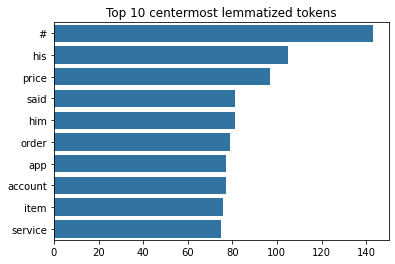

In [406]:
sns.barplot(y=list(lt2_top_10.index), x=lt2_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost lemmatized tokens")
#plt.savefig('../images/top_10_lt2');

Let's be even more restrictive on the upper and lower token frequencies.

In [409]:
lt4 = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=15, max_df=.01)

In [410]:
X_train_lt4 = pd.DataFrame(lt4.fit_transform(X_train).A, columns=lt4.get_feature_names_out())
X_test_lt4 = pd.DataFrame(lt4.transform(X_test).A, columns=lt4.get_feature_names_out())
X_train_lt4.head(5)

,12,5.,7,accept,active,activity,added,adding,adult,advance,...,washing,wear,wet,white,wife,willing,win,writing,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296352,0.0,0.149678
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [411]:
# verifying column size match
print(X_train_lt4.shape, X_test_lt4.shape)

(1857, 204) (619, 204)


In [412]:
X_train_lt4.shape[1] - X_train_cvec.shape[1]

-12169

We have 12,169 less columns here when compared to the default vectorization.

In [415]:
lt4_top_10 = X_train_lt4.sum().sort_values(ascending=False)[:10]

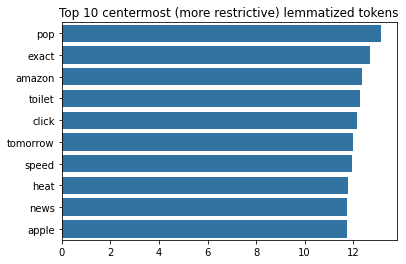

In [418]:
sns.barplot(y=list(lt4_top_10.index), x=lt4_top_10.values, orient='h', color='tab:blue')
plt.title("Top 10 centermost (more restrictive) lemmatized tokens")
#plt.savefig('../images/top_10_lt4');

With all our features engineered in various ways, let's store them and fit them into various models to see what results we can produce.<br />
Recall that with an unbalanced dataset, our goal is to get strong recall, precision and F1 scores.

In [423]:
# saving engineered train test splits for modeling
stored_data['X_train_cvec'] = X_train_cvec
stored_data['X_test_cvec'] = X_test_cvec
stored_data['X_train_cvec2'] = X_train_cvec2
stored_data['X_test_cvec2'] = X_test_cvec2
stored_data['X_train_cvec3'] = X_train_cvec3
stored_data['X_test_cvec3'] = X_test_cvec3
stored_data['X_train_cvec4'] = X_train_cvec4
stored_data['X_test_cvec4'] = X_test_cvec4

stored_data['X_train_tf'] = X_train_tf
stored_data['X_test_tf'] = X_test_tf
stored_data['X_train_tf2'] = X_train_tf2
stored_data['X_test_tf2'] = X_test_tf2
stored_data['X_train_tf3'] = X_train_tf3
stored_data['X_test_tf3'] = X_test_tf3
stored_data['X_train_tf4'] = X_train_tf4
stored_data['X_test_tf4'] = X_test_tf4
stored_data['X_train_tf5'] = X_train_tf5
stored_data['X_test_tf5'] = X_test_tf5

stored_data['X_train_lt'] = X_train_lt
stored_data['X_test_lt'] = X_test_lt
stored_data['X_train_lt2'] = X_train_lt2
stored_data['X_test_lt2'] = X_test_lt2
stored_data['X_train_lt4'] = X_train_lt4
stored_data['X_test_lt4'] = X_test_lt4

stored_data['y_train_encoded'] = y_train_encoded
stored_data['y_test_encoded'] = y_test_encoded

In [424]:
%store stored_data
del stored_data

Stored 'stored_data' (dict)
